In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplitModel

from pyspark.ml.clustering import KMeans, KMeansSummary

from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
#env variables
model_path = "file:///home/work/data/kmeans_movies_model"
model_clusters = 140

In [3]:
# Change the number of cores in this code block
# by setting `spark.master` to `local[n]` where
# n is the number of cores

conf = pyspark.SparkConf().setAll([('spark.master', 'local[4]'),
                                   ('spark.app.name', 'KMEANS Clustering')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-30 01:45:27,938 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read in data

In [4]:
train_df = spark.read.option("header",True).csv("file:///home/work/data/kmeans_movies_train/", inferSchema=True)
test_df = spark.read.option("header",True).csv("file:///home/work/data/kmeans_movies_test/", inferSchema=True)

In [5]:
col_names = train_df.columns
exc_cols = ['movieId', 'title', 'genres', 'movieYear']
feat_cols = sorted(list(set(col_names).difference(set(exc_cols))))

In [6]:
assembler = VectorAssembler(inputCols=feat_cols, outputCol='features', handleInvalid='skip')
train = assembler.transform(train_df)
test = assembler.transform(test_df)

In [7]:
tvsModel = TrainValidationSplitModel.read().load(model_path)
cluster_list = list(range(10,1501,10))
evaluator = ClusteringEvaluator(predictionCol='prediction',
                          featuresCol='features',
                          metricName='silhouette',
                          distanceMeasure='cosine')

train_score = evaluator.evaluate(tvsModel.transform(train))
test_score = evaluator.evaluate(tvsModel.transform(test))
print(f"Train score: {train_score} Test score: {test_score}")

2022-05-30 01:45:40,337 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Train score: 0.6355963350995041 Test score: 0.5725490613357676


## Model comparison

K: 140 cosine score: 0.6029447511074769
K: 1350 cosine score: 0.6031929712453477


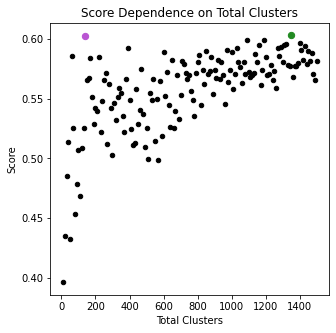

In [8]:
plt.figure(figsize=(5,5))
scores_i = np.where(np.array(tvsModel.validationMetrics) >= 0.6)[0]
plt.scatter(cluster_list, tvsModel.validationMetrics, color='black', s=20)
colors = ['mediumorchid','forestgreen']
for i, s_i in enumerate(scores_i):
    s_k = (s_i + 1) * 10
    print(f'K: {s_k} cosine score: {tvsModel.validationMetrics[s_i]}')
    plt.scatter(s_k, tvsModel.validationMetrics[s_i], color=colors[i], s=40)
plt.ylabel('Score')
plt.xlabel('Total Clusters')
plt.title('Score Dependence on Total Clusters')
plt.savefig('../../data/kmeans_scatter.png')

0.6029447511074769


Train eval with 140 clusters: Train: 0.5352356173647969 Test: 0.540881080013947
Clusters with less than 10 observations: 2
0.6031929712453477


Train eval with 1350 clusters: Train: 0.6355963350995041 Test: 0.5725490613357676
Clusters with less than 10 observations: 968


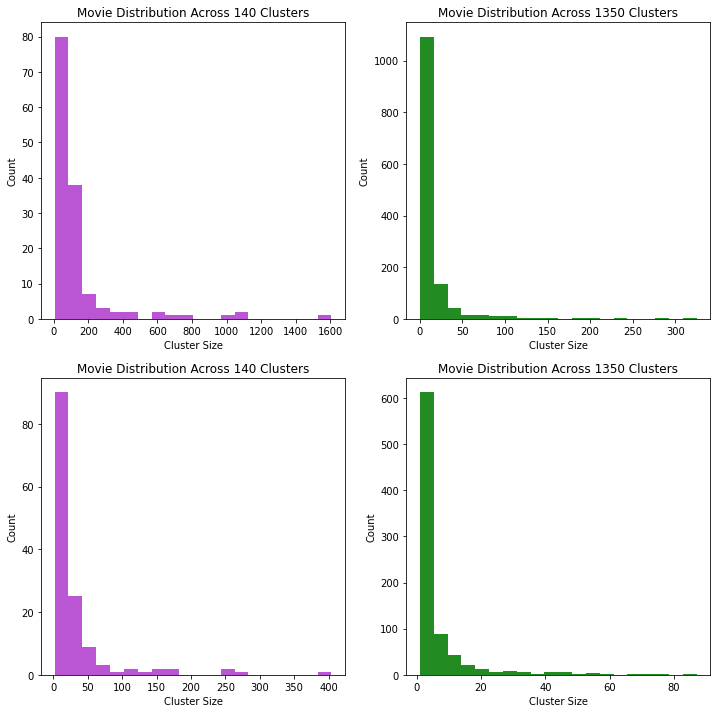

In [9]:
plt.figure(figsize=(12,12))
train_i = 1
test_i = 3
for i, s_i in enumerate(scores_i):
    print(tvsModel.validationMetrics[s_i])
    s_k = (s_i + 1) * 10
    kmeans = KMeans(k=s_k, featuresCol='features', seed=0, maxIter=1000, distanceMeasure="cosine")
    mood = kmeans.fit(train)
    s_k_train = evaluator.evaluate(mood.transform(train))
    s_k_test = evaluator.evaluate(mood.transform(test))
    small_clusters = np.where(np.array(mood.summary.clusterSizes) <= 10)[0]
    tot_small = len(small_clusters)
    print(f"Train eval with {s_k} clusters: Train: {s_k_train} Test: {s_k_test}")
    print(f"Clusters with less than 10 observations: {tot_small}")
    # plot train
    plt.subplot(2,2,train_i)
    _, _, _ = plt.hist(mood.summary.clusterSizes,bins=20,color=colors[i])
    plt.title(f'Movie Distribution Across {s_k} Clusters')
    plt.xlabel('Cluster Size')
    plt.ylabel('Count')
    # plot test
    transformed = mood.transform(test)
    h = transformed.select('prediction').groupBy('prediction').count()
    h = h.select('count').toPandas()
    plt.subplot(2,2,test_i)
    _, _, _ = plt.hist(h['count'],bins=20,color=colors[i])
    plt.title(f'Movie Distribution Across {s_k} Clusters')
    plt.xlabel('Cluster Size')
    plt.ylabel('Count')
    # update plot counters
    train_i = train_i + 1
    test_i = test_i + 1
plt.savefig('../../data/kmeans_model_comparison.png')

## Pick model and train

In [10]:
kmeans = KMeans(k=model_clusters, featuresCol='features', seed=0, maxIter=1000, distanceMeasure="cosine")
model = kmeans.fit(train)
transformed = model.transform(test)

In [11]:
model_pred_genres = model.summary.predictions.select('genres', 'prediction').groupBy('genres', 'prediction').count()
large_clusters = np.where(np.array(model.summary.clusterSizes) >= 900)[0]
large_clusters = np.insert(large_clusters, 0, 1)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [12]:
# Get train info
train_genres = model.summary.predictions.select('genres', 'prediction').groupBy('genres', 'prediction').count()
train_stats = model.summary.predictions.select('avg_rating', 'prediction')
# Get test info
test_genres = transformed.select('genres', 'prediction').groupBy('genres', 'prediction').count()
test_stats = transformed.select('genres', 'prediction').groupBy('genres', 'prediction').count()

## Examine some clusters

In [13]:
for l in large_clusters:
    print(f"CLUSTER ID: {l}")
    print(f"----------TRAIN-----------------")
    train_genres.filter(train_genres.prediction == int(l)).select('genres','count').show(truncate=False)
    print(train_stats.filter(train_stats.prediction == int(l)).describe().toPandas())
    print(f"----------TEST-----------------")
    test_genres.filter(test_genres.prediction == int(l)).select('genres','count').show(truncate=False)
    print(test_stats.filter(test_stats.prediction == int(l)).describe().toPandas())

CLUSTER ID: 1
----------TRAIN-----------------
+---------------------------+-----+
|genres                     |count|
+---------------------------+-----+
|Action|Comedy|Crime|Romance|4    |
|Action|Comedy|Crime|Horror |1    |
|Action|Comedy|Crime|Western|1    |
|Action|Comedy|Crime|Mystery|1    |
|Action|Comedy|Crime        |60   |
+---------------------------+-----+

  summary          avg_rating prediction
0   count                  67         67
1    mean  3.0149167321620465        1.0
2  stddev  0.4584579990170097        0.0
3     min  1.8717948717948718          1
4     max  3.8518737809974923          1
----------TEST-----------------
+---------------------------+-----+
|genres                     |count|
+---------------------------+-----+
|Action|Comedy|Crime|Romance|1    |
|Action|Comedy|Crime        |9    |
+---------------------------+-----+

  summary                       genres prediction              count
0   count                            2          2               

## Examine similar clusters

In [14]:
sim_clusters = [13,27]
for l in sim_clusters:
    print(f"CLUSTER ID: {l}")
    print(f"----------TRAIN-----------------")
    train_genres.filter(train_genres.prediction == int(l)).select('genres','count').show(truncate=False)
    print(train_stats.filter(train_stats.prediction == int(l)).describe().toPandas())
    print(f"----------TEST-----------------")
    test_genres.filter(test_genres.prediction == int(l)).select('genres','count').show(truncate=False)
    print(test_stats.filter(test_stats.prediction == int(l)).describe().toPandas())

CLUSTER ID: 13
----------TRAIN-----------------
+--------------+-----+
|genres        |count|
+--------------+-----+
|Comedy        |623  |
|Comedy|War    |4    |
|Comedy|Mystery|4    |
|Comedy|Western|7    |
+--------------+-----+

  summary           avg_rating prediction
0   count                  638        638
1    mean   2.6481201493536495       13.0
2  stddev  0.22563261271340423        0.0
3     min   2.1522727272727273         13
4     max   2.9722222222222223         13
----------TEST-----------------
+--------------+-----+
|genres        |count|
+--------------+-----+
|Comedy        |168  |
|Comedy|War    |2    |
|Comedy|Mystery|1    |
|Comedy|Western|1    |
+--------------+-----+

  summary          genres prediction              count
0   count               4          4                  4
1    mean            None       13.0               43.0
2  stddev            None        0.0  83.33466665600017
3     min          Comedy         13                  1
4     max  Comedy|

In [15]:
spark.stop()